In [0]:
%matplotlib inline
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
plt.ion()

In [0]:
# Utility parent class for MLP functional support
class MLP_Utilities:

    def parse_raw_data(self, filename):
        """ Parse 2-D datapoints and labels from a raw file
        filename: Path to file containing raw data
        return datapoints: x0 and x1 matrix of input data
        return labels: labels associated with datapoints
        """
        # Set up empty vectors for capturing data from train.dat
        x0 = []
        x1 = []
        labels = []

        # Open the file and parse the data
        with open(filename, 'r') as f:
            data = f.readlines()
            for N, i in enumerate(data):
                row = i.rstrip().lstrip().split(",")
                for j in row:
                    num = j.rstrip().lstrip().split("  ")
                    x0.append(float(num[0]))
                    x1.append(float(num[1]))
                    labels.append(float(num[2]))
        N += 1 # Adjust for the offset starting at 0

        # Join the x inputs into a matrix
        datapoints = np.vstack((x0, x1))
        datapoints = np.vstack((np.ones((1, N)), datapoints))  # N points of (d + 1) dimensions, with 1st dim = 1.
        labels = np.asarray(labels).reshape(N, 1)
        return datapoints, labels

    def sign(self, x):
        """ Step function for determining sign
        x: Float to evaluate sign for
        return +1/-1: vectorized signs of an array
        """
        return 1. if x >= 0 else -1.
        self.vsign = np.vectorize(self.sign)  # vectorize the function so it can apply elementwise op to array and return array

    def mse(self, pred, target):
        """ Mean Squared Error for prediction and target
        pred: The prediction
        target: The known output
        return mse: mean squared error of predition and target
        """
        return (pred - target)**2

    def theta(self, x):
        """ Activation function of MLP (currently tanh)
        x: array to evaluate
        return theta: result of the activation
        """
        return np.tanh(x)

    def theta_prime(self, x):
        """ Backpropagation of activation function of MLP (currently tanh)
        x: array to evaluate
        return theta': result of the activation derivative
        """
        return 1 - np.tanh(x)**2

    def unison_shuffle(self, datapoints, labels):
        """ Shuffle two arrays while maintaining their indexing relation
        datapoints: Datapoints to shuffle
        labels: Labels to shuffle
        return datapoints: Shuffled datapoints
        return labels: Shuffled labels
        """
        p = np.random.permutation(len(labels))  # Create a common permutation for the arrays
        datapoints = datapoints.T               # Transpose the datapoints into column vectors
        datapoints = datapoints[p]              # Shuffle the datapoints
        datapoints = datapoints.T               # Transpose the datapoints back to row vectors 
        labels = labels[p]                      # Shuffle the labels
        return datapoints, labels

    def __plot_2d_data(self, datapoints, labels, title=None):
        """ Plots a 2-dimensional, binary data set
        datapoints: x-input, 2 dimensional location
        labels: Label corresponding to each x-input
        """
        # Find the min/max of the input data
        min1 = np.min(datapoints[1])
        max1 = np.max(datapoints[1])
        min2 = np.min(datapoints[2])
        max2 = np.max(datapoints[2])

        # Categorize the data
        X_plus = np.asarray([datapoints.T[row] for row in range(datapoints.T.shape[0]) if labels[row] > 0])
        X_minus = np.asarray([datapoints.T[row] for row in range(datapoints.T.shape[0]) if labels[row] < 0])

        # Setting up the matplotlib plot....
        fig, ax = plt.subplots()
        ax.plot(X_plus[:, [1]], X_plus[:, [2]], 'ro', label='X Plus')
        ax.plot(X_minus[:, [1]], X_minus[:, [2]], 'bo', label='X Minus')
        ax.set_xlim((min1 + min1/10), (max1 + max1/10))
        ax.set_ylim((min2 + min2/10), (max2 + max2/10))
        _ = ax.legend()
        if title:
            ax.set_title(title)

    def plot_training_data(self):
        """ Plot the 2-d training data """
        self.__plot_2d_data(self.X_train, self.y_train, "The Training Data")
    
    def plot_test_data(self):
        """ Plot the 2-d testing data """
        self.__plot_2d_data(self.X_test, self.y_test, "The Test Data")
    
    def plot_error(self, error_list, total_epochs):
        """ Plot the error rate
        error_list: List of average error corresponding to the epochs
        total_epochs: Total number of epochs in a training run
        """
        x = np.arange(1, total_epochs+1)
        y = error_list
        fig, ax = plt.subplots()
        print(f'\n weights: {self.weight_range}    eta: {self.eta}    neurons: {self.hidden_neurons}')
        ax.set_xlim(1, (total_epochs+1))
        ax.set_ylim((np.min(error_list)-np.min(error_list)/10), (np.max(error_list)+np.max(error_list)/100))
        ax.plot(x, y)
        plt.show()


In [0]:
# Multi-Layer Perceptron with 1-5 neurons in a single hidden layer
class MLP(MLP_Utilities):

    def __init__(self, seed, train_file, test_file, hidden_neurons, weight_range, eta):
        """ Initialize the MLP
        seed: Seed for randomizing numpy
        train_file: The training data file
        test_file: The testing data file
        hidden_neurons: Number of neurons in hidden layer
        weight range: 'large' for (-2., 2.) or 'small' for (-0.02, 0.02) weight initialization
        eta: Learning rate
        """
        np.random.seed(seed)
        self.eta = eta
        self.hidden_neurons = hidden_neurons
        self.X_train, self.y_train = self.parse_raw_data(train_file)
        self.X_test, self.y_test = self.parse_raw_data(test_file)
        self.weight_range = weight_range
        self.vsign = np.vectorize(self.sign)  # vectorize the function so it can apply elementwise op to array and return array

        # Generate random weights for input and output layers
        self.input_weights = np.zeros((self.X_train.shape[0], self.hidden_neurons))
        if (weight_range == 'small'):
            with np.nditer(self.input_weights, op_flags=['readwrite']) as it:
                for x in it:
                    x[...] = np.random.uniform(-0.02, 0.02)
            self.output_weights = np.random.uniform(-0.02, 0.02, hidden_neurons+1).reshape(hidden_neurons+1, 1)
        else:
            with np.nditer(self.input_weights, op_flags=['readwrite']) as it:
                for x in it:
                    x[...] = np.random.uniform(-2., 2.)
            self.output_weights = np.random.uniform(-2., 2., hidden_neurons+1).reshape(hidden_neurons+1, 1)

    def __forward(self, x):
        """ Foward pass function
        x: Input vector with bias appended to position 0
        return out: Output of forward pass of the network
        """
        self.x0 = x
        self.signal_0 = np.dot(self.input_weights.T, self.x0)               # Calculate input/hidden layer signal
        self.x1 = self.theta(self.signal_0)                                 # Perform activation function on hidden layer
        self.x1 = np.append(1, self.x1).reshape((self.hidden_neurons+1, 1)) # Append bias and convert to a column vector
        self.signal_1 = np.dot(self.output_weights.T, self.x1)              # Calculate output layer signal
        out = self.theta(self.signal_1).item()                              # Perform activation function on output
        return out

    def __backward(self, nn_out, label):
        """ Backward pass function
        nn_out: Output of forward pass
        label: Associated label with forward pass output
        return G1: Gradient of layer L
        return G2: Gradient of layer L-1
        """
        # Calculate layer deltas
        delta_L2 = 2 * (nn_out - label) * self.theta_prime(nn_out)
        delta_L1 = self.theta_prime(self.signal_1) * self.output_weights[1:self.hidden_neurons+1] * delta_L2
        # Calculate layer gradients
        G1 = self.x1 * delta_L2.T
        G2 = self.x0 * delta_L1.T
        return G1, G2

    def predict(self, x):
        """ Predict a +1 or -1 for a given input vector
        x: Input vector to make prediction for
        return prediction: Label prediction of an input vector
        """
        return self.vsign(self.__forward(x))

    def train(self, iterations):
        """ Train the model using SGD
        iterations: Number of epochs to train for
        """
        error_list = np.empty(iterations)
        for epoch in range(iterations):
            total_loss = 0
            self.X_train, self.y_train = self.unison_shuffle(self.X_train, self.y_train)
            for i in range(self.y_train.shape[0]):
                label = self.y_train[i]
                out = self.__forward(self.X_train[:, i].reshape(3, 1))
                total_loss += self.mse(out, label).item()
                G1, G2 = self.__backward(out, label)
                self.output_weights = self.output_weights - self.eta * G1
                self.input_weights = self.input_weights - self.eta * G2 
            average_error = total_loss / self.y_train.shape[0]
            error_list[epoch] = average_error
        self.plot_error(error_list, iterations)

    def __evaluate_training(self):
        """ Evaluate the current weights for the training data
        """
        mislabeled = 0
        for i in range(self.y_train.shape[0]):
            out = self.predict(self.X_train[:, i].reshape(3, 1))
            #print(f'out = {out}   label = ')
            if not out == self.y_train[i]:
                mislabeled += 1
        error = mislabeled/self.y_train.shape[0]
        print(f'training error: {error:.2%}')

    def __evaluate_testing(self):
        """ Evaluate the current weights for the test data
        """
        mislabeled = 0
        for i in range(self.y_test.shape[0]):
            out = self.predict(self.X_test[:, i].reshape(3, 1))
            #print(f'out = {out}   label = ')
            if not out == self.y_test[i]:
                mislabeled += 1
        error = mislabeled/self.y_test.shape[0]
        print(f'testing error: {error:.2%}')

    def evaluate(self):
        """ Evaluate the current weights
        """
        self.__evaluate_training()
        self.__evaluate_testing()


**Part A**


 weights: small    eta: 0.1    neurons: 1


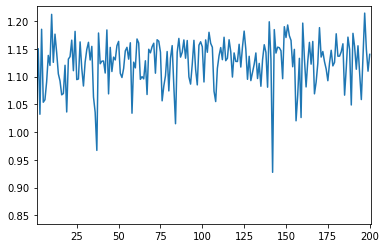

training error: 44.00%
testing error: 47.20%

 weights: small    eta: 0.1    neurons: 2


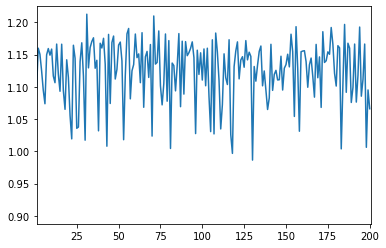

training error: 56.00%
testing error: 52.80%

 weights: small    eta: 0.1    neurons: 3


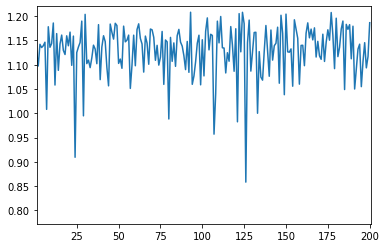

training error: 44.00%
testing error: 47.20%

 weights: small    eta: 0.1    neurons: 4


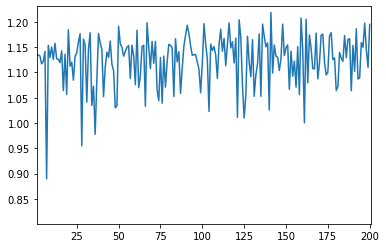

training error: 44.00%
testing error: 47.20%

 weights: small    eta: 0.1    neurons: 5


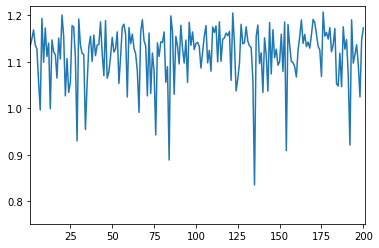

training error: 24.00%
testing error: 27.60%

 weights: large    eta: 1.0    neurons: 1


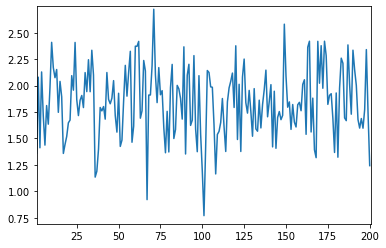

training error: 36.00%
testing error: 41.60%

 weights: large    eta: 1.0    neurons: 2


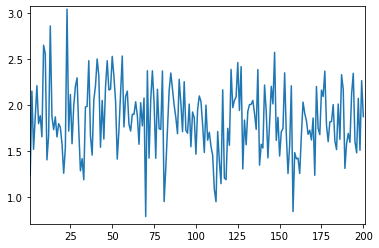

training error: 56.00%
testing error: 52.80%

 weights: large    eta: 1.0    neurons: 3


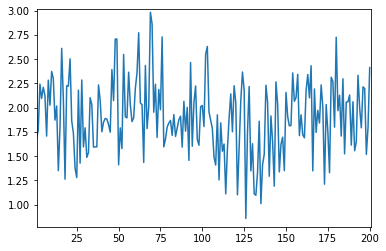

training error: 48.00%
testing error: 54.80%

 weights: large    eta: 1.0    neurons: 4


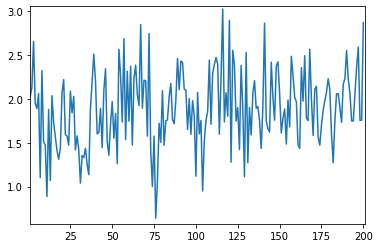

training error: 40.00%
testing error: 42.40%

 weights: large    eta: 1.0    neurons: 5


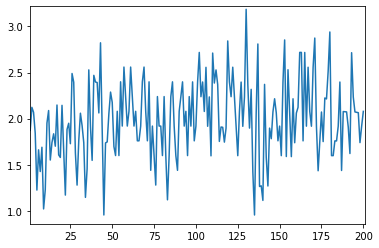

training error: 56.00%
testing error: 52.80%

 weights: large    eta: 0.1    neurons: 1


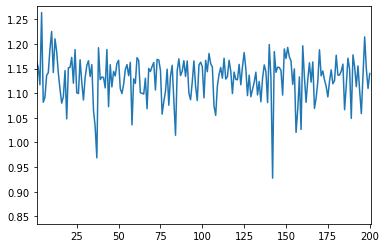

training error: 44.00%
testing error: 47.20%

 weights: large    eta: 0.1    neurons: 2


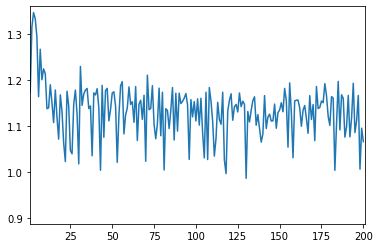

training error: 56.00%
testing error: 52.80%

 weights: large    eta: 0.1    neurons: 3


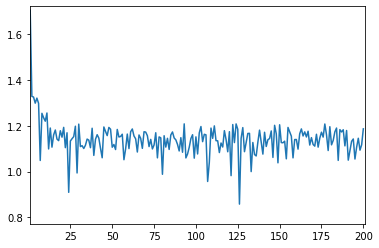

training error: 44.00%
testing error: 47.20%

 weights: large    eta: 0.1    neurons: 4


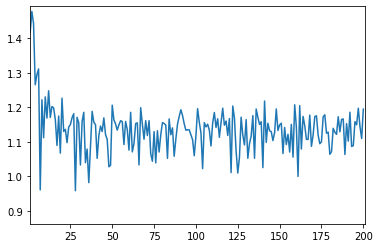

training error: 44.00%
testing error: 47.20%

 weights: large    eta: 0.1    neurons: 5


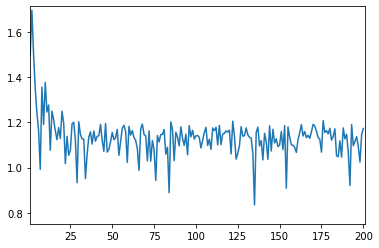

training error: 24.00%
testing error: 27.60%

 weights: large    eta: 0.01    neurons: 1


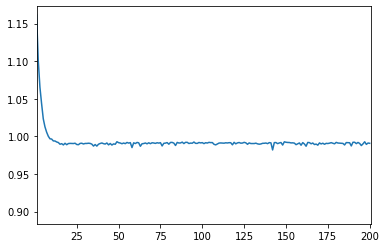

training error: 60.00%
testing error: 54.80%

 weights: large    eta: 0.01    neurons: 2


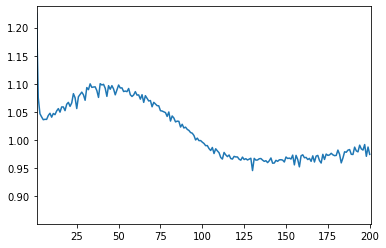

training error: 48.00%
testing error: 46.80%

 weights: large    eta: 0.01    neurons: 3


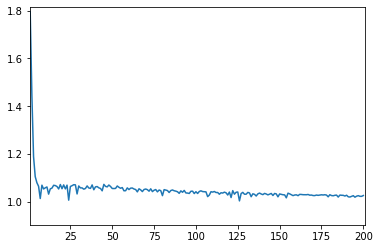

training error: 44.00%
testing error: 47.20%

 weights: large    eta: 0.01    neurons: 4


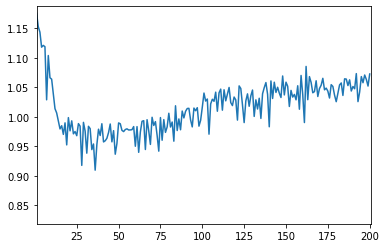

training error: 44.00%
testing error: 47.60%

 weights: large    eta: 0.01    neurons: 5


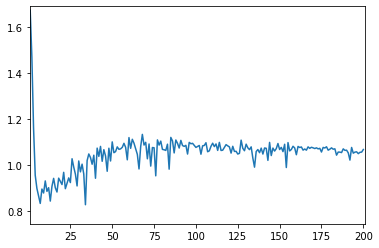

training error: 60.00%
testing error: 62.80%


In [4]:
# Set hidden neurons to 1-5
# Set the weight range to 'small' (-0.02, 0.02) or 'large' (-2, 2)
# Set eta to 0.01, 0.1, or 1.0

for neurons in range(1,6):
    mlp = MLP(seed=2, train_file='train.dat', test_file='test.dat', hidden_neurons=neurons, weight_range='small', eta=.1)
    mlp.train(iterations=200)
    mlp.evaluate()

for neurons in range(1,6):
    mlp = MLP(seed=2, train_file='train.dat', test_file='test.dat', hidden_neurons=neurons, weight_range='large', eta=1.)
    mlp.train(iterations=200)
    mlp.evaluate()

for neurons in range(1,6):
    mlp = MLP(seed=2, train_file='train.dat', test_file='test.dat', hidden_neurons=neurons, weight_range='large', eta=.1)
    mlp.train(iterations=200)
    mlp.evaluate()

for neurons in range(1,6):
    mlp = MLP(seed=2, train_file='train.dat', test_file='test.dat', hidden_neurons=neurons, weight_range='large', eta=.01)
    mlp.train(iterations=200)
    mlp.evaluate()



For 200 iterations, the best model had large weights, eta=0.1, and 5 neurons with 24% training error and 27.6% testing error

**Part B**


 weights: small    eta: 0.1    neurons: 1


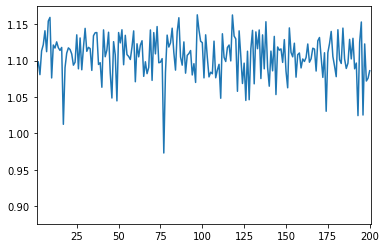

training error: 37.20%
testing error: 40.00%

 weights: small    eta: 0.1    neurons: 2


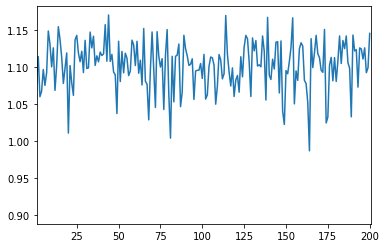

training error: 47.20%
testing error: 44.00%

 weights: small    eta: 0.1    neurons: 3


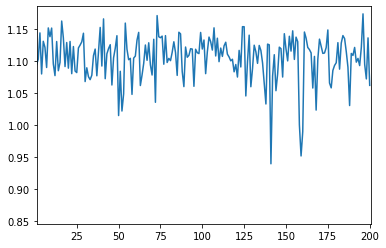

training error: 47.20%
testing error: 44.00%

 weights: small    eta: 0.1    neurons: 4


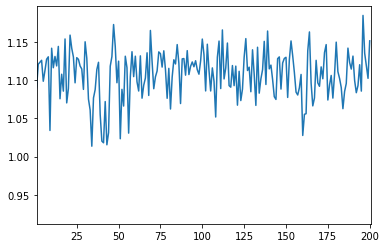

training error: 47.20%
testing error: 44.00%

 weights: small    eta: 0.1    neurons: 5


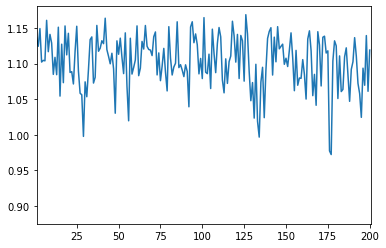

training error: 52.80%
testing error: 56.00%

 weights: large    eta: 1.0    neurons: 1


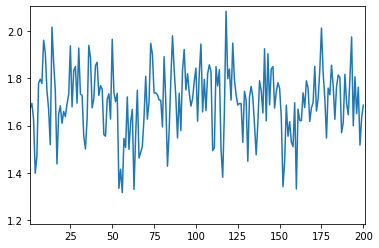

training error: 48.80%
testing error: 56.00%

 weights: large    eta: 1.0    neurons: 2


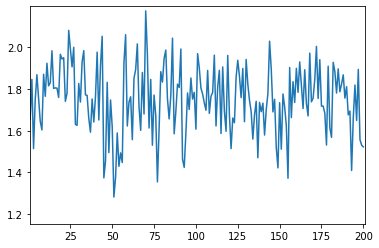

training error: 42.00%
testing error: 36.00%

 weights: large    eta: 1.0    neurons: 3


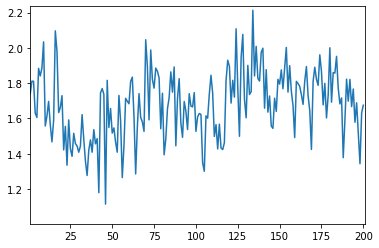

training error: 47.20%
testing error: 44.00%

 weights: large    eta: 1.0    neurons: 4


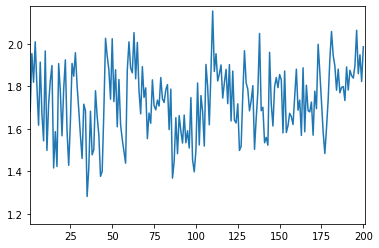

training error: 47.20%
testing error: 44.00%

 weights: large    eta: 1.0    neurons: 5


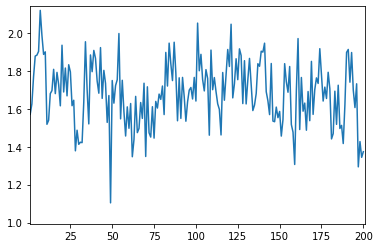

training error: 32.40%
testing error: 36.00%

 weights: large    eta: 0.1    neurons: 1


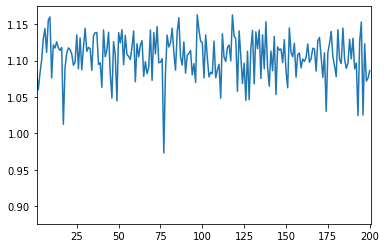

training error: 37.20%
testing error: 40.00%

 weights: large    eta: 0.1    neurons: 2


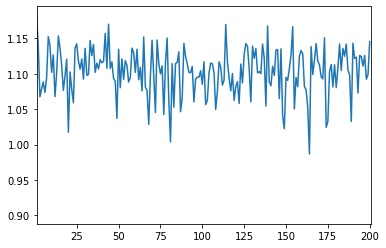

training error: 47.20%
testing error: 44.00%

 weights: large    eta: 0.1    neurons: 3


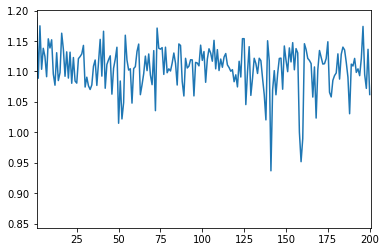

training error: 47.20%
testing error: 44.00%

 weights: large    eta: 0.1    neurons: 4


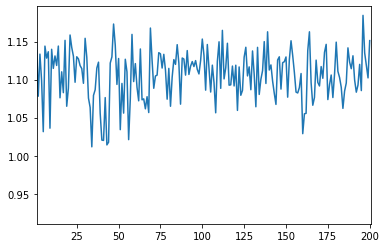

training error: 47.20%
testing error: 44.00%

 weights: large    eta: 0.1    neurons: 5


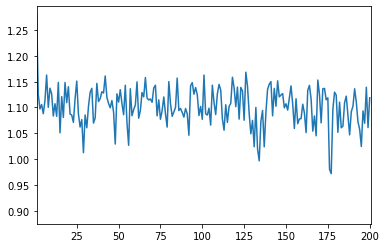

training error: 52.80%
testing error: 56.00%

 weights: large    eta: 0.01    neurons: 1


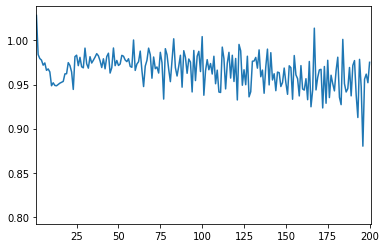

training error: 36.40%
testing error: 40.00%

 weights: large    eta: 0.01    neurons: 2


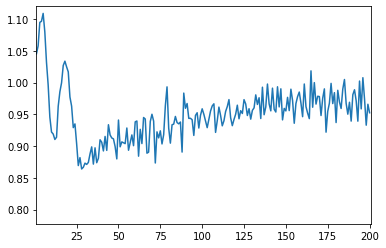

training error: 42.00%
testing error: 40.00%

 weights: large    eta: 0.01    neurons: 3


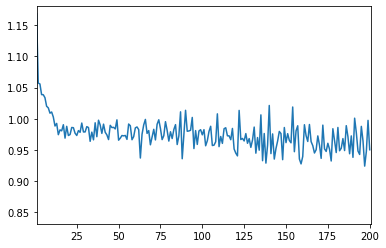

training error: 51.20%
testing error: 44.00%

 weights: large    eta: 0.01    neurons: 4


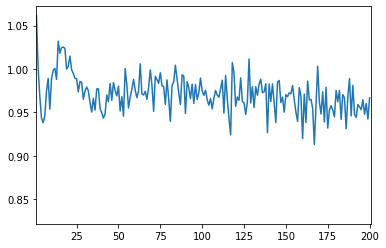

training error: 33.20%
testing error: 40.00%

 weights: large    eta: 0.01    neurons: 5


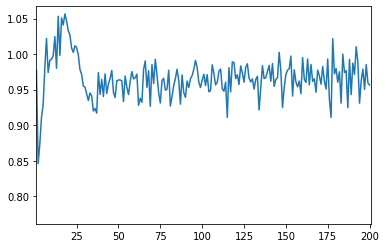

training error: 32.80%
testing error: 36.00%


In [5]:
for neurons in range(1,6):
    mlp = MLP(seed=2, train_file='test.dat', test_file='train.dat', hidden_neurons=neurons, weight_range='small', eta=.1)
    mlp.train(iterations=200)
    mlp.evaluate()

for neurons in range(1,6):
    mlp = MLP(seed=2, train_file='test.dat', test_file='train.dat', hidden_neurons=neurons, weight_range='large', eta=1.)
    mlp.train(iterations=200)
    mlp.evaluate()

for neurons in range(1,6):
    mlp = MLP(seed=2, train_file='test.dat', test_file='train.dat', hidden_neurons=neurons, weight_range='large', eta=.1)
    mlp.train(iterations=200)
    mlp.evaluate()

for neurons in range(1,6):
    mlp = MLP(seed=2, train_file='test.dat', test_file='train.dat', hidden_neurons=neurons, weight_range='large', eta=.01)
    mlp.train(iterations=200)
    mlp.evaluate()

For 200 iterations, the best model had large weights, eta=1.0, and 5 neurons with 32.4% training error and 36% testing error